In [2]:
import importlib
import experiment

# Reload the experiment module
importlib.reload(experiment)

# Run the main function
experiment.main()

c:\Users\simon\OneDrive - Australian National University\ANU\2024 sem 2\Enviromental\Project\data\experiment.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['months'] = (dataset['date'].dt.year - min_year) * 12 + dataset['date'].dt.month - 1
c:\Users\simon\OneDrive - Australian National University\ANU\2024 sem 2\Enviromental\Project\data\experiment.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['months'] = (dataset['date'].dt.year - min_year) * 12 + dataset['date'].dt.month - 1


Running LSTM_AllLosses on agg.raw_CCCMA3.1_R1_hist
Training on cpu
Training the LSTM...
tensor(0.0725, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0596, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0468, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0340, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0253, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0261, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0250, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0318, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0354, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0364, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0356, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0331, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0292, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0284, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0300, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0336, grad_fn=<MeanBackward0>) tensor(0.7348)
tensor(0.0354, grad_fn=<MeanBack

KeyboardInterrupt: 

In [2]:
import pandas as pd
import scipy.stats as stats
%matplotlib ipympl
from matplotlib import pyplot as plt
import numpy as np
from bias_correction import BiasCorrection, XBiasCorrection
from base import QuantileMapping
from torch_bias_corrector import LSTM_BiasCorrector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from metric import *


In [3]:


# Read the text file into a DataFrame
# df = pd.read_csv('MATH3133_mv/all_vars.txt', delimiter='\s+')
# df.columns = ['date', 'name', 'lat', 'lon', 'value']

df = pd.read_csv('221212.csv')

# Convert 'dayno' to datetime
df['date'] = pd.to_datetime('1989-12-31') + pd.to_timedelta(df['dayno'], unit='D')

# Calculate the day of the year
df['day_of_year'] = df['date'].dt.dayofyear

# Calculate sine and cosine of the day of the year
df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

train_df = df[:len(df) // 2]
validation_df = df[len(df) // 2:]

# Define months as an integer for each datapoint representing how far into the dataset it is
train_df['months'] = (train_df['date'].dt.year - train_df['date'].dt.year.min()) * 12 + train_df['date'].dt.month -1 
validation_df['months'] = (validation_df['date'].dt.year - validation_df['date'].dt.year.min()) * 12 + validation_df['date'].dt.month -1

# Convert months to numpy arrays
train_months = train_df['months'].values
validation_months = validation_df['months'].values


C:\Users\simon\AppData\Local\Temp\ipykernel_9440\1407175009.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['months'] = (train_df['date'].dt.year - train_df['date'].dt.year.min()) * 12 + train_df['date'].dt.month -1
C:\Users\simon\AppData\Local\Temp\ipykernel_9440\1407175009.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['months'] = (validation_df['date'].dt.year - validation_df['date'].dt.year.min()) * 12 + validation_df['date'].dt.month -1


In [4]:
train_column = 'agg.raw_CCCMA3.1_R1_hist'
gt_column = 'agg.AWAP'

normaliser = StandardScaler(with_mean=False)
train = normaliser.fit_transform(train_df[train_column].values.reshape(-1, 1))
target = normaliser.transform(train_df[gt_column].values.reshape(-1, 1))

# Add sine and cosine of the day of the year
# train = np.concatenate([train, train_df[['sin_day', 'cos_day']].values], axis=1)

valid_input = normaliser.transform(validation_df[train_column].values.reshape(-1, 1))
valid_target = normaliser.transform(validation_df[gt_column].values.reshape(-1, 1))

# Add sine and cosine of the day of the year
# valid_input = np.concatenate([valid_input, validation_df[['sin_day', 'cos_day']].values], axis=1)

min_rain = 0.1
scaled_rain = normaliser.transform(np.array([[min_rain]])).item()

model_lstm = LSTM_BiasCorrector(train, target,
                        [MonthlyAverageLoss(scaled_rain, train_months), MonthlyMaxLoss(scaled_rain, train_months)],   
                        [1/1.7162, 0.5*1/60.0838, 1.],
                        input_size=1,
                        lr=1e-5)

model = model_lstm
# model = QuantileMapping(train, target)
model.train(epochs=1000)


Training the LSTM...
Epoch [100/1000], Loss: 1.4094
Loss 1: 0.1564
Loss 2: 1.2530
Epoch [200/1000], Loss: 1.4094
Loss 1: 0.1564
Loss 2: 1.2530
Epoch [300/1000], Loss: 1.4094
Loss 1: 0.1564
Loss 2: 1.2530
Epoch [400/1000], Loss: 1.4094
Loss 1: 0.1564
Loss 2: 1.2530
Epoch [500/1000], Loss: 1.4094
Loss 1: 0.1564
Loss 2: 1.2530
Epoch [600/1000], Loss: 1.4094
Loss 1: 0.1564
Loss 2: 1.2530
Epoch [700/1000], Loss: 1.4094
Loss 1: 0.1564
Loss 2: 1.2530
Epoch [800/1000], Loss: 1.4094
Loss 1: 0.1564
Loss 2: 1.2530
Epoch [900/1000], Loss: 1.4094
Loss 1: 0.1564
Loss 2: 1.2530
Epoch [1000/1000], Loss: 1.4094
Loss 1: 0.1564
Loss 2: 1.2530


C:\Users\simon\AppData\Local\Temp\ipykernel_9440\485344410.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').mean()
c:\Users\simon\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\simon\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation between corrected and input: nan


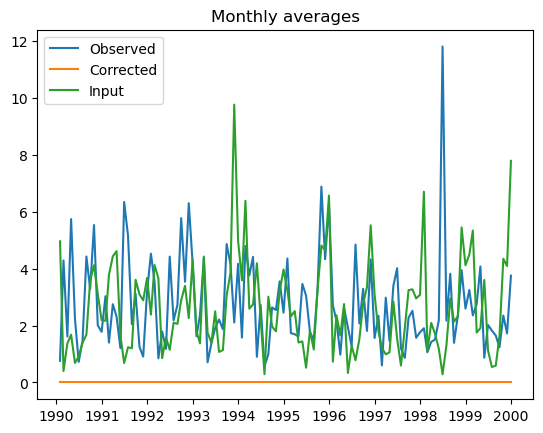

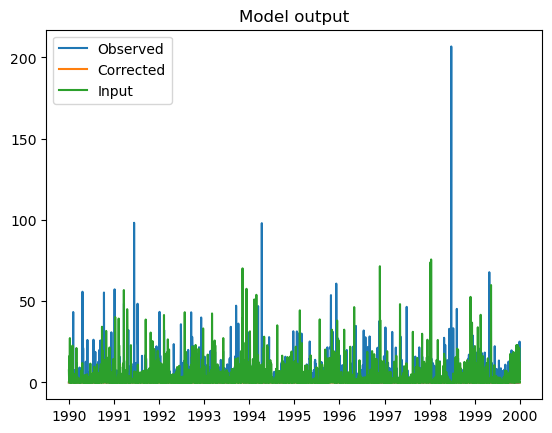

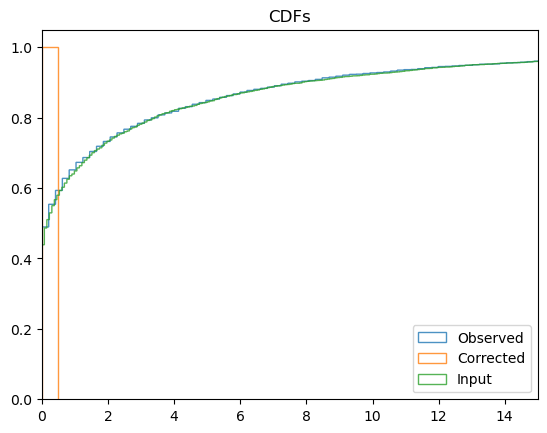

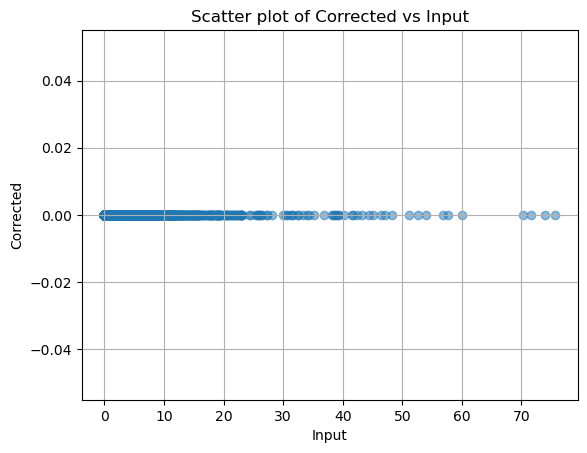

In [5]:
# total_input = np.concatenate([train, valid_input])
# total_target = np.concatenate([target, valid_target])
# total_input = np.concatenate([valid_input])
# total_target = np.concatenate([valid_target])
total_input = np.concatenate([train])
total_target = np.concatenate([target])

pred = model.predict(total_input)

total_input = normaliser.inverse_transform(total_input)
pred = normaliser.inverse_transform(pred)
total_target = normaliser.inverse_transform(total_target)

# Convert arrays to DataFrame for easier manipulation
data = pd.DataFrame({
    'date': train_df['date'],
    # 'date': validation_df['date'],
    'total_target': total_target.flatten(),
    'pred': pred.flatten(),
    'total_input': total_input[:,0].flatten()
})

# Set the date as the index
data.set_index('date', inplace=True)

# Resample to monthly frequency and calculate the mean
monthly_data = data.resample('M').mean()

# Plot the monthly averages
plt.figure()
plt.title('Monthly averages')
plt.plot(monthly_data['total_target'], label='Observed')
plt.plot(monthly_data['pred'], label='Corrected')
plt.plot(monthly_data['total_input'], label='Input')
plt.legend()
# plt.savefig('figures/monthly_averages.png')

# Plot the monthly averages
plt.figure()
plt.title('Model output')
plt.plot(data['total_target'], label='Observed')
plt.plot(data['pred'], label='Corrected')
plt.plot(data['total_input'], label='Input')
plt.legend()
# plt.savefig('figures/data.png')


plt.figure()
plt.title('CDFs')
plt.hist(data['total_target'], bins=1000, alpha=0.8, label='Observed', density=True, cumulative=True, histtype='step')
plt.hist(data['pred'], bins=200, alpha=0.8, label='Corrected', density=True, cumulative=True, histtype='step')
plt.hist(data['total_input'], bins=1000, alpha=0.8, label='Input', density=True, cumulative=True, histtype='step')
plt.xlim(0, 15)
plt.legend()
# plt.savefig('figures/cdfs.png')

# Calculate the correlation between 'pred' and 'total_input'
correlation = data['pred'].corr(data['total_input'])
print(f'Correlation between corrected and input: {correlation}')

# Create a scatter plot to visualize the correlation
plt.figure()
plt.title('Scatter plot of Corrected vs Input')
plt.scatter(data['total_input'], data['pred'], alpha=0.5)
plt.xlabel('Input')
plt.ylabel('Corrected')
plt.grid(True)
# plt.savefig('figures/scatter.png')
plt.show()


In [1]:
# Make a table with the loss evaluated on the validation set
losses = [loss(torch.Tensor(valid_input), torch.Tensor(valid_target)) for loss in model_lstm.losses]
print('Losses on validation set:')
for loss, value in zip([loss.__class__.__name__ for loss in model_lstm.losses], losses):
    print(f'{loss}: {value}')

if isinstance(model, LSTM_BiasCorrector):
    print(model.loss_coeff)
    print(np.array(model.loss_data)[:,0])

# Calculate the PDF of each distribution dataset
target_pdf, target_bins = np.histogram(data['total_target'], bins=200, density=True)/float(len(data['total_target']))
pred_pdf, pred_bins = np.histogram(data['pred'], bins=200, density=True)/float(len(data['pred']))

# Calculate the maximum distance between the PDFs
max_distance = np.max(np.abs(target_pdf - pred_pdf[:len(target_pdf)]))
print(f'Maximum distance between target and prediction PDFs: {max_distance}')



NameError: name 'model_lstm' is not defined

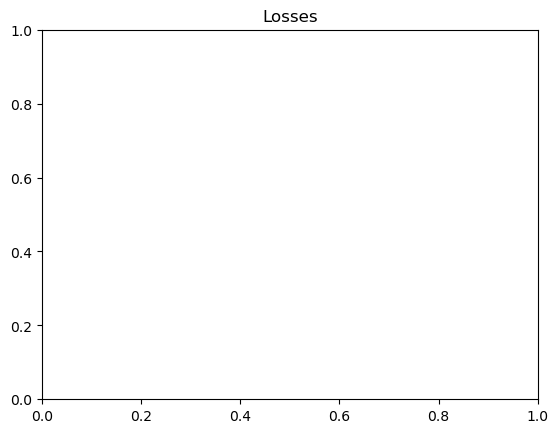

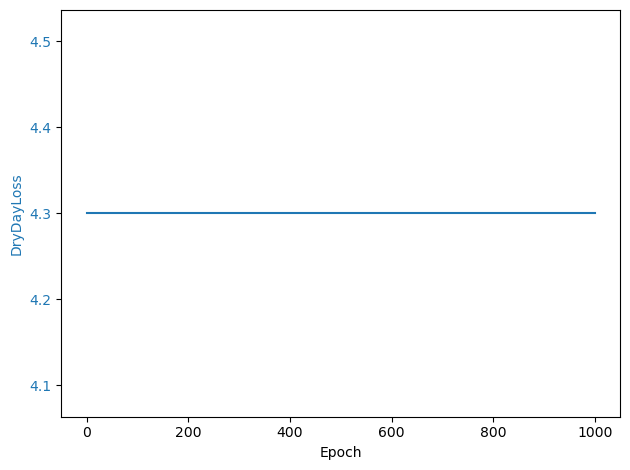

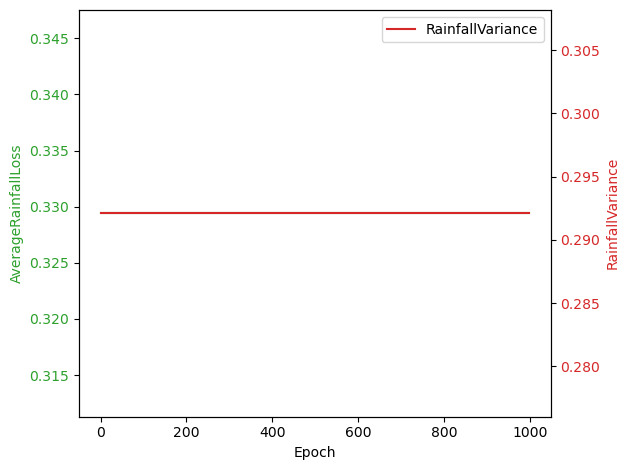

In [6]:
plt.title('Losses')
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel(model.losses[0].__class__.__name__, color=color)
ax1.plot(np.array(model.loss_data)[0], label=model.losses[0].__class__.__name__, color=color)
ax1.tick_params(axis='y', labelcolor=color)


# ax2 = ax1.twinx()
# color = 'tab:orange'
# ax2.set_ylabel(model.losses[1].__class__.__name__, color=color)
# ax2.plot(np.array(model.loss_data)[1], label=model.losses[1].__class__.__name__, color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# plt.savefig('figures/losses12.png')


fig.tight_layout()

fig, ax3 = plt.subplots()

color = 'tab:green'
ax3.set_xlabel('Epoch')
ax3.set_ylabel(model.losses[2].__class__.__name__, color=color)
ax3.plot(np.array(model.loss_data)[2], label=model.losses[2].__class__.__name__, color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel(model.losses[3].__class__.__name__, color=color)
ax4.plot(np.array(model.loss_data)[3], label=model.losses[3].__class__.__name__, color=color)
ax4.tick_params(axis='y', labelcolor=color)

# plt.savefig('figures/losses34.png')

fig.tight_layout()
plt.legend()
plt.show()